# LMC Analysis: Part I
## Mock Observables from Models of the Large Magellanic Cloud
### Author: Chad Bustard

This notebook goes through a few analyses of simulation data, specifically the simulations published in Bustard et al. 2020 of ram pressure stripping and supernova-driven outflows from the Large Magellanic Cloud. 

#### Main publication: https://ui.adsabs.harvard.edu/abs/2020ApJ...893...29B/abstract

In this notebook (part I), we will extract a few mock observables from the dataset, including rotation measure (which is a probe of magnetic field strength), gamma-ray emission (which probes cosmic ray content), and ion column densities. Then we'll make a few mock absorption line spectra comparable to that from the COS-Halos spectrograph aboard the Hubble Space Telescope.

In part II, we will plot values of "ram pressure" across the LMC disk and tabulate them at specific points where there are observational sightlines (this part, followed by an analysis of correlations between local ram pressure and observed ion abundances forms the basis for a funded Hubble Space Telescope (HST) grant (PI: Yong Zheng, Co-I: Chad Bustard)

#### Order of operations:
1. Why do these simulations?
2. What goes into these simulations?
3. What do the simulations look like?
4. Simulation analysis -- mock observations
    
#### Python-based packages used: 
Pandas, yt, Trident, astropy    

## Background
### Why were these simulations created?

How gas flows in and out of galaxies is an important and open question in galaxy formation and evolution. Large-scale supernova-driven outflows (or winds) from galaxies are prevalent throughout the Universe and can greatly impact galaxy evolution by quenching star formation and redistributing metals from the inner galaxy to the circumgalactic medium. The composition of these outflows and the physical processes that drive them, however, are not well understood, and there are large discrepancies between observations and theory. This project closes those gaps by creating synthetic, multi-wavelength observations of outflow simulations to be compared to observations from Chandra, HST, JWST, and other current and future telescopes. 

Specifically, our simulations focus on the Large Magellanic Cloud (LMC), a dwarf galaxy roughly 50 kiloparsecs from the Milky Way that exhibits evidence for galactic winds. The LMC also has a rich interaction history with its neighbor, the Small Magellanic Cloud (SMC), which allows us to probe how a galaxy’s environment affects outflow generation and dynamics. While falling into the Milky Way halo, the Clouds orbit around each other, triggering bursts of star formation and also tearing each other apart as their gravitational forces loosen and strip material. Combined with the constant headwind they experience during their infall, their galactic dance flings gas behind the Clouds, contributing to the Trailing Magellanic Stream. This massive gaseous tail extending tens of kiloparsecs behind the Clouds may someday fall onto the Milky Way disk and enhance our Galactic ecosystem by providing more fuel to form stars. Fortunately, because of our birds-eye view, the Magellanic System gives us an incredible window into how galaxies expel and feed on gas; both the large-scale gas cycles in and between galaxies, as well as the small-scale, internal processes that drive gas flows. 

More specifically, this project looks at the generation of supernova-driven outflows from the LMC and their interaction with ram pressure, the pressure that a galaxy feels as it moves through a static background. Individually, these processes are known to oppose gravity and remove gas from galaxies, but in concert, their effects are less well known.


### What goes into these simulations?

In Bustard et al. 2018, we modeled individual, idealized gas outbursts from the LMC and their interaction with a headwind directed parallel to the LMC disk axis. 

Here, in Bustard et al. 2020, we increase complexity and realism in important ways:

1. We use active particles in FLASH to represent clusters of stars that evolve and explode over a given time period, depositing energy and momentum to the surrounding cells according to the fitting functions of Martizzi et al. 2015 and the star cluster implementation of Semenov et al. 2016.

2. Part of the energy released from supernovae goes into cosmic rays. Cosmic rays are relativistic particles, comprising only about a billionth of all particles in the Milky Way, but their energies are so high that, collectively, the cosmic ray population has an equal importance to galaxy dynamics and thermodynamics. Cosmic rays are of specific interest because of their ability to help launch galactic outflows. The FLASH cosmic ray module we employ has been used in numerous galaxy-scale simulations as well as in recent localized simulations of a stratified ISM made unstable by cosmic ray streaming (Heintz, Bustard, and Zweibel 2020).

3. Probably the most novel part of these simulations...the creation of star cluster particles is directly tied to the spatially resolved star formation history of the LMC! Small-scale structures resolved by observations of the Magellanic Clouds, as well as the reconstructed star formation histories of the Clouds, afford us the opportunity to test the cumulative effects of various physical processes on outflow and fountain generation. Specifically, we have included into our model the derived star formation sites in the LMC over the past billion years. This is done by reading in data files containing the star formation rate at over 1300 (x,y) coordinates at 10 time snapshots. In between these coarse time snapshots, we randomly draw cluster masses from a probability distribution function, which we can vary, and populate each (x,y) coordinate with star clusters such that the total mass formed as stars matches the total mass known to form during that time interval. We leave the number of star forming events as a free parameter; fewer events necessitates either larger mass particles or more particles per event (supernovae that are more clustered), while more frequent events necessitates lower mass particles. This allows us to probe the effects of supernova clustering on outflow generation. 


### What do the full simulations look like?
The video below shows volume renderings of the LMC gas pressure over the course of a billion (simulated) years of LMC evolution, including the generation of supernova-driven outflows and ram pressure stripping of loosely connected gas. 

In the following cells, we'll take a closer look at the simulation data ourselves...

In [1]:
from IPython import display
display.Video("Image_Video_Files/movie_GasPres_timeseries.mp4", embed=True)

In [1]:
# Import all the packages we need
!pip install --upgrade yt
!pip install trident
import yt
import trident
from trident import LightRay
import aplpy
import numpy as np
#import matplotlib as plt
from yt.units.yt_array import YTQuantity
from yt import YTArray
import h5py
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy import wcs
from astropy.wcs import WCS
import csv
import pandas as pd

!pip install cmasher # a nice repository of colorblind-friendly, aesthetically pleasing colormaps
import cmasher as cmr

Requirement already up-to-date: yt in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages (4.1.4)
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
# Get the HDF5 file from my Google Drive
# Note: Can delete this cell if the HDF5 file is already downloaded
!pip install gdown
!gdown "https://drive.google.com/uc?id=1BCvIdYOA3VZj91Fdh9seOki0ww3Rqiky"

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Downloading...
From (uriginal): https://drive.google.com/uc?id=1BCvIdYOA3VZj91Fdh9seOki0ww3Rqiky
From (redirected): https://drive.google.com/uc?id=1BCvIdYOA3VZj91Fdh9seOki0ww3Rqiky&confirm=t&uuid=0427425c-d735-4768-a9d9-e60cabc7c48f
To: /Users/chad/Desktop/research_overview/research_overview/LMC_Analysis_Examples/windCRs_hdf5_plt_cnt_0050
100%|████████████████████████████████████████| 668M/668M [00:19<00:00, 34.7MB/s]


## A first look at the simulation data
For the remainder of this notebook, we employ the `yt` package, a visualization and analysis toolkit for astrophysics: https://yt-project.org/. 

Let's start by loading the present-day LMC snapshot and printing off the fields that `yt` knows about. Then let's take a look at density and temperature slices of the simulations parallel and perpendicular to the axis of the disk.

In [3]:
# Load our dataset with yt
yt.enable_parallelism() # for large data files (or multiple files), yt can be parallelized with this command. Here we don't need it

# general way to load in a series of snapshots, in this case just the final snapshot of the 50 I output during the simulation
ds = yt.load("windCRs_hdf5_plt_cnt_0050")

dd = ds.all_data()

# just giving the simulation box periodic boundaries (so we can calculate gradients if we want to without throwing errors)
#ds.periodicity=(True,True,True)
        
# rearranging coordinates 
ds.coordinates.x_axis[1] = 0
ds.coordinates.y_axis[1] = 2

# Let's take a look at all the quantities or "fields" known to yt derived from the ~10 output variables in the HDF5 file
print(ds.derived_field_list)


yt : [ERROR    ] 2023-05-09 09:03:43,583 Could not enable parallelism: only one mpi process is running. To remedy this, launch the Python interpreter as
  mpirun -n <X> python3 <yourscript>.py  # with X > 1 
yt : [INFO     ] 2023-05-09 09:03:43,763 Parameters: current_time              = 3.156010944496386e+16
yt : [INFO     ] 2023-05-09 09:03:43,765 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2023-05-09 09:03:43,769 Parameters: domain_left_edge          = [-6.171e+22 -6.171e+22 -6.171e+22]
yt : [INFO     ] 2023-05-09 09:03:43,772 Parameters: domain_right_edge         = [1.234e+23 1.234e+23 1.234e+23]
yt : [INFO     ] 2023-05-09 09:03:43,773 Parameters: cosmological_simulation   = 0


[('flash', 'cell_volume'), ('flash', 'cloo'), ('flash', 'cray'), ('flash', 'dens'), ('flash', 'dx'), ('flash', 'dy'), ('flash', 'dz'), ('flash', 'haco'), ('flash', 'hrat'), ('flash', 'igm '), ('flash', 'ism '), ('flash', 'magx'), ('flash', 'magy'), ('flash', 'magz'), ('flash', 'mtl '), ('flash', 'path_element_x'), ('flash', 'path_element_y'), ('flash', 'path_element_z'), ('flash', 'pres'), ('flash', 'temp'), ('flash', 'velx'), ('flash', 'vely'), ('flash', 'velz'), ('flash', 'volume'), ('flash', 'x'), ('flash', 'y'), ('flash', 'z'), ('gas', 'alfven_speed'), ('gas', 'angular_momentum_magnitude'), ('gas', 'angular_momentum_x'), ('gas', 'angular_momentum_y'), ('gas', 'angular_momentum_z'), ('gas', 'averaged_density'), ('gas', 'baroclinic_vorticity_magnitude'), ('gas', 'baroclinic_vorticity_x'), ('gas', 'baroclinic_vorticity_y'), ('gas', 'baroclinic_vorticity_z'), ('gas', 'cell_mass'), ('gas', 'cell_volume'), ('gas', 'courant_time_step'), ('gas', 'cutting_plane_magnetic_field_x'), ('gas', '

Let's take a quick look at the simulations to see what we have. We'll start with Slice plots, which just look at a 2D array of cells, both in the plane of the disk and vertical to the plane of the disk. 

yt : [INFO     ] 2023-04-10 12:24:56,383 xlim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:56,384 ylim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:56,386 xlim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:56,388 ylim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:56,393 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800



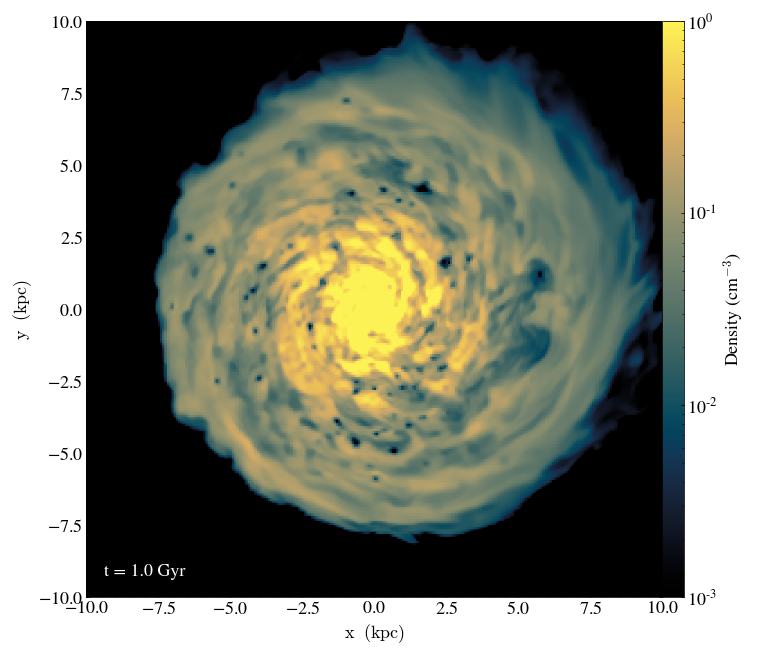

yt : [INFO     ] 2023-04-10 12:24:57,219 xlim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:57,220 ylim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:57,221 xlim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:57,222 ylim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:57,225 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800



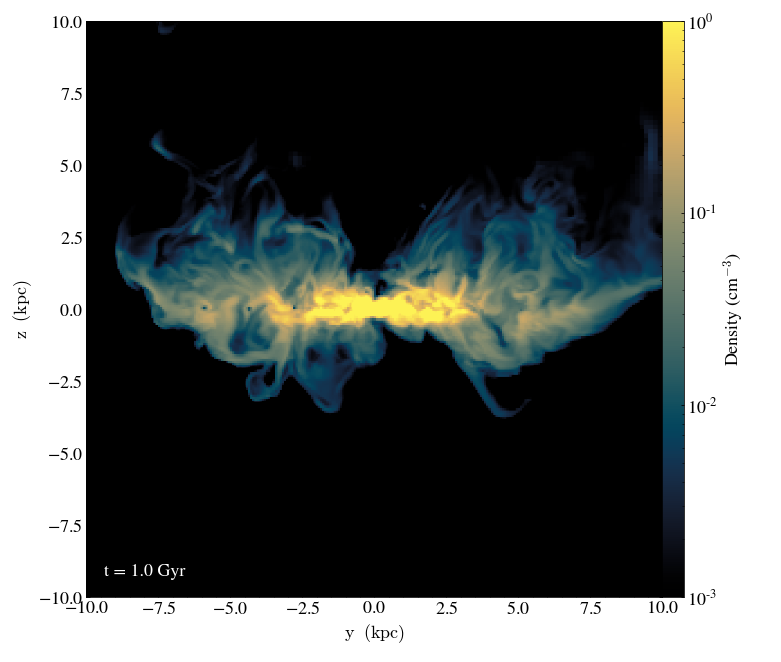

yt : [INFO     ] 2023-04-10 12:24:58,065 xlim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:58,066 ylim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:58,070 xlim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:58,071 ylim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:58,075 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



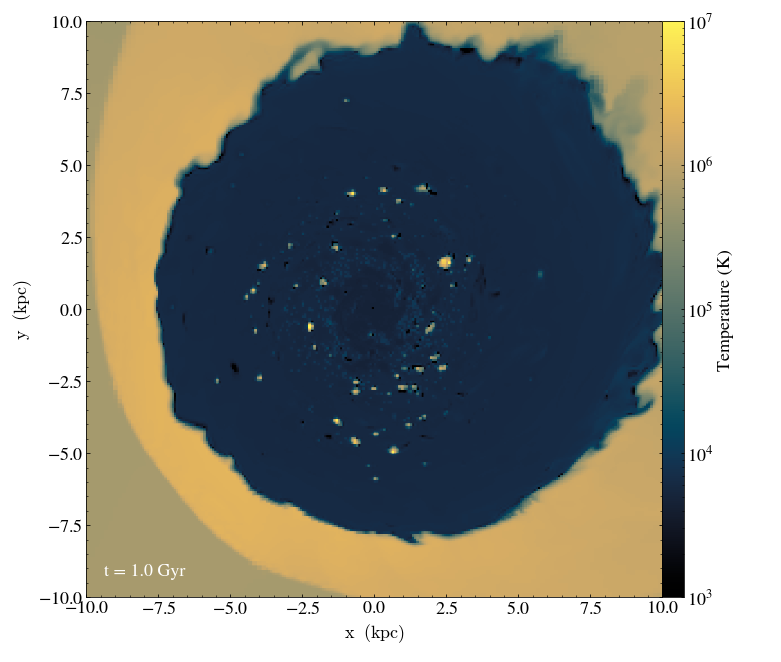

yt : [INFO     ] 2023-04-10 12:24:58,991 xlim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:58,991 ylim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:58,992 xlim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:58,993 ylim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-04-10 12:24:58,998 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



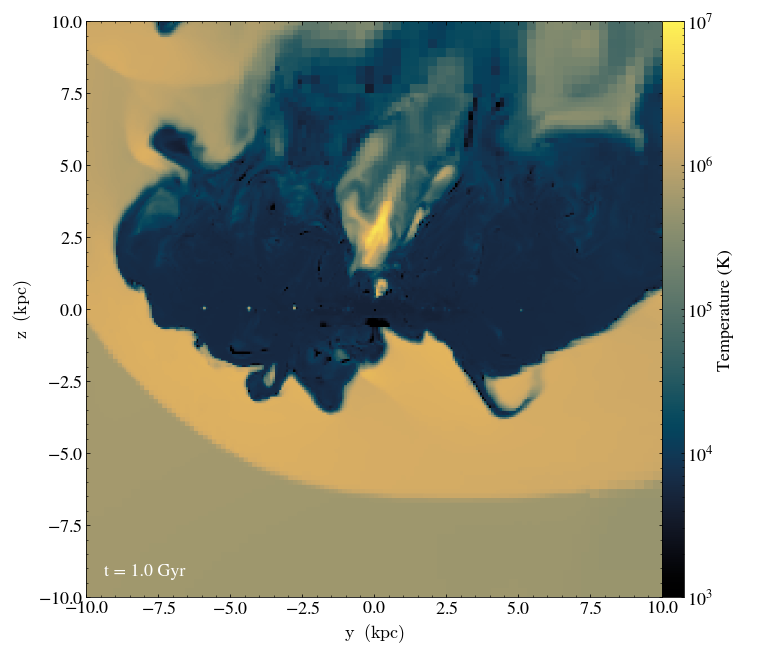

In [13]:
# Plot a slice of the hydrogen number density -- # of hydrogen particles per cubic centimeter -- in the plane of the disk
field = ("gas","number_density")
proj = yt.SlicePlot(ds, "z", field,center = (0,0,0), width=(20, 'kpc'))
proj.set_cmap(field=field, cmap='cmr.eclipse')
proj.set_colorbar_label(field, r"Density (cm$^{-3}$)")
proj.set_zlim(field,1e-3,1e0)
proj.annotate_timestamp()
proj.show()

proj = yt.SlicePlot(ds, "x", field,center = (0,0,0), width=(20, 'kpc'))
proj.set_cmap(field=field, cmap='cmr.eclipse')
proj.set_colorbar_label(field, r"Density (cm$^{-3}$)")
proj.set_zlim(field,1e-3,1e0)
proj.annotate_timestamp()
proj.show()

field = ("gas","temperature")
proj = yt.SlicePlot(ds, "z", field,center = (0,0,0), width=(20, 'kpc'))
proj.set_cmap(field=field, cmap='cmr.eclipse')
proj.set_colorbar_label(field, r"Temperature (K)")
proj.set_zlim(field,1e3,1e7)
proj.annotate_timestamp()
proj.show()

proj = yt.SlicePlot(ds, "x", field,center = (0,0,0), width=(20, 'kpc'))
proj.set_cmap(field=field, cmap='cmr.eclipse')
proj.set_colorbar_label(field, r"Temperature (K)")
proj.set_zlim(field,1e3,1e7)
proj.annotate_timestamp()
proj.show()

We can see a lot of interesting physics at play here, as well as some info about the simulation methodology. 

First, you might notice in the last figure, which shows a vertical view of the temperature, that the actual cells of the simulation are noticeable in the region far above the disk. This is because we *derefine* the grid in areas with lower density. The cells are more densely spaced near the center of the galaxy, specifically at regions where the gas density is highest; this technique is called adaptive mesh refinement (AMR) and is commonly used to focus resolution on certain areas of the simulation box. In this case, every n timesteps in the simulation (here set to be ~100 timesteps), the grid will re-assess the gas density and restructure itself. This technique saves on computation time and memory. If the entire simulation domain were tiled by small cells, the simulation would be intractable.  

Second, check out the structures that have formed in the LMC disk. Clusters of supernova explosions have heated and ejected the gas (as one can see in the vertical slices), carving out hot, diffuse holes surrounded by dense shells. This is exactly what we see when we observe a neutral hydrogen map of the LMC, and we will confirm that later in this exercise when we create mock HI column density maps, as well as maps of other common and useful ions. 

Of course, this is just an example "slice" in the plane of the disk. In reality, we see the full, integrated column of gas along our line of sight, which is at an angle to the disk orientation. Let's show that view instead...

yt : [INFO     ] 2023-05-09 09:03:59,361 xlim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-05-09 09:03:59,362 ylim = -30856775809623249649664.000000 30856775809623249649664.000000
yt : [INFO     ] 2023-05-09 09:03:59,362 zlim = -92554999999999995019264.000000 92554999999999995019264.000000
yt : [INFO     ] 2023-05-09 09:03:59,370 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800



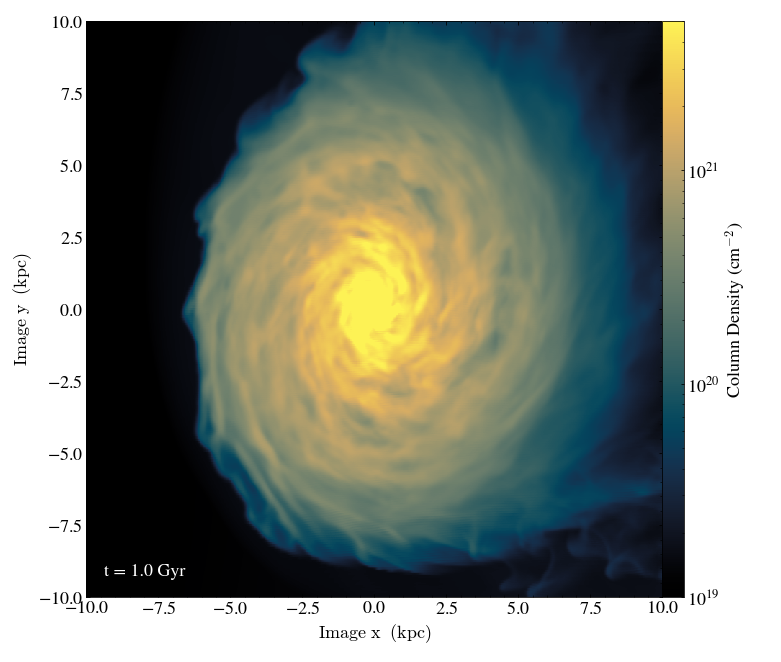

In [4]:
# density projection along the line of sight
L = [-0.561,0.099,0.822] # vector normal to cutting plane
north_vector = [0,0,1]

# Plot the column density (projected density)  
field = ("gas","number_density")
proj = yt.OffAxisProjectionPlot(ds, L, field,center = (0,0,0), width=(20, 'kpc'))
proj.set_cmap(field=field, cmap='cmr.eclipse')
proj.set_colorbar_label(field, r"Column Density (cm$^{-2}$)")
proj.set_zlim(field,1.E19, 5.E21)
proj.annotate_timestamp()
proj.show()


## Towards a better comparison to real observations
So far we've made a column density map along the line-of-sight to the LMC, which is a good start, but that is still not exactly what we get from observations. 

1. Observations are typically plotted in Right Ascension (RA), Declination (DEC) coordinates
2. Observations never give us the *full* gas density...instead we obtain abundances of different ions, which exist at certain densities and temperatures
3. Ion abundances are obtained through e.g. absorption line spectroscopy. So what we ultimately want, to best compare to observations, are maps of various ion column densities and mock absorption lines through different sightlines. 

Let's start by using the `astropy` package to convert from simulation coordinates to RA, DEC coordinates

In [5]:
# Restrict our plot to just the galaxy (cells with an ISM tag > 0.6)
cut_data = dd.cut_region('(obj["ism "] > 0.6)')

prj_fits = yt.FITSOffAxisProjection(ds,L,field,center = (0,0,0),width=(20, 'kpc'),data_source=cut_data)
sky_center = [79.0,-68.68] # in degrees, what Jack told me to use
sky_scale = (4123.71, "arcsec/kpc") # could also use a YTQuantity
prj_fits.create_sky_wcs(sky_center, sky_scale, ctype=["RA---TAN","DEC--TAN"], replace_old_wcs=True)
prj_fits.writeto("LMC_H.fits",overwrite=True)

yt : [INFO     ] 2023-05-09 09:05:34,442 Making a FITS image of field number_density


In [6]:
# We'll plot images multiple times, so let's make this a function

# Requires: file -- file name, e.g. "LMC_H.fits"
# Requires: ion -- ion name, e.g. "H"
# Requires: min_max = (min, max) of field value for colorbar = (1e19,5e21) by default
def plotFits(file,ion,min_max=(1e19,5e21)):
    image_data = fits.getdata(file)
    print(type(image_data))
    print(image_data.shape)

    vmin,vmax = min_max
    fig = aplpy.FITSFigure(file)
    fig.add_grid()
    fig.show_colorscale(cmap="cmr.eclipse",stretch = 'log', vmin=vmin, vmax = vmax)
    fig.tick_labels.set_xposition("top")
    fig.ticks.set_xspacing(8.0)
    fig.ticks.set_yspacing(8.0)
    fig.add_colorbar()
    fig.colorbar.set_axis_label_text(ion + r' Column Density (cm$^{-2}$)')
 
    # fig.tick_labels.set_xformat('hh:mm')
    fig.tick_labels.set_xformat('dd')
    fig.tick_labels.set_yformat('dd')
    # fig.set_theme('pretty')
    #fig.colorbar.show(log_format=False)
    fig.colorbar.set_font(size=20)



<class 'numpy.ndarray'>
(512, 512)


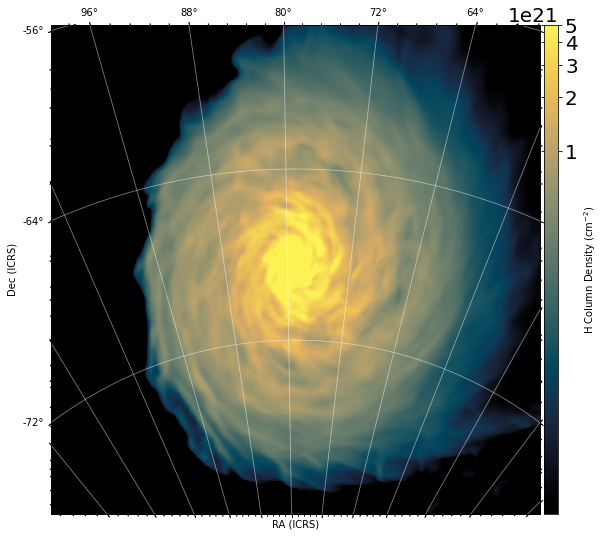

In [19]:
plotFits("LMC_H.fits", "H",min_max=(1e19,5e21))

Let's now separate out different ions instead of showing the full gas column density. Here, we use the Trident package, which assumes that the gas is in photoionization equilibrium (PIE) with the metagalactic UV background. I wrote a new radiative cooling / heating routine in the FLASH simulations that uses the same assumption, calculating cooling rates as a function of the evolving gas density, metallicity, and temperature. So this is a consistent assumption.

In [7]:
# I've created and output a few relevant *tracers* with values in [0,1] from the FLASH simulations: metallicity and concentration of ISM (interstellar medium) matter
# Trident needs the metallicity field to be called "metallicity", so do this here..
def _metallicity(field, data):
    val = data['mtl ']
    return val

# add the new metallicity field and weight it by ISM concentration so we preferentially select the galaxy instead of the background
ds.add_field(('gas', 'metallicity'), function=_metallicity, units='dimensionless',sampling_type='cell', force_override=True)

# Based on that metallicity and the PIE assumption, tell Trident to calculate HI, HII, and OVI abundances
# Note: As of YT 4.0, these fields seem to be included without needing to add them with Trident. 
trident.add_ion_fields(ds, ions=['H I', 'H II', 'Si IV', 'O VI'], ftype="gas")

# create all the projections, write them to FITS files for later use, and make initial mock images
# this may take a few minutes
prj_fits = yt.FITSOffAxisProjection(ds,L,'H_p0_number_density',center = (0,0,0),width=(20, 'kpc'),data_source=cut_data)
prj_fits.create_sky_wcs(sky_center, sky_scale, ctype=["RA---TAN","DEC--TAN"], replace_old_wcs=True)
prj_fits.writeto("LMC_HI.fits", overwrite=True)

prj_fits = yt.FITSOffAxisProjection(ds,L,'H_p1_number_density',center = (0,0,0),width=(20, 'kpc'),data_source=cut_data)
prj_fits.create_sky_wcs(sky_center, sky_scale, ctype=["RA---TAN","DEC--TAN"], replace_old_wcs=True)
prj_fits.writeto("LMC_HII.fits", overwrite=True)


yt : [INFO     ] 2023-05-09 09:06:56,054 Making a FITS image of field H_p0_number_density
yt : [INFO     ] 2023-05-09 09:07:50,542 Making a FITS image of field H_p1_number_density


<class 'numpy.ndarray'>
(512, 512)
<class 'numpy.ndarray'>
(512, 512)


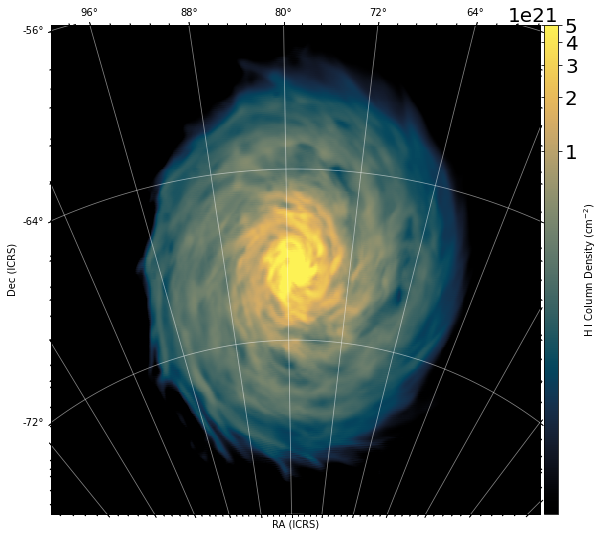

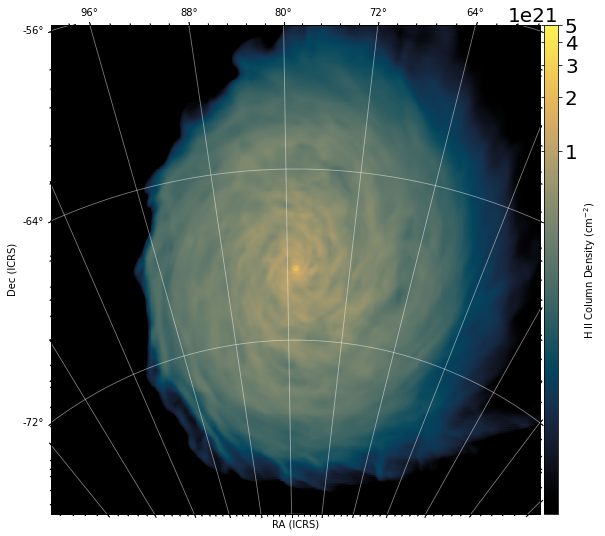

In [22]:
# Make images
plotFits("LMC_HI.fits", "H I")
plotFits("LMC_HII.fits", "H II")

HI probes neutral hydrogen, which is quite abundant in the LMC disk

HII probes singly ionized hydrogen. The fact that there is a significant column of ionized hydrogen suggests that estimates of total LMC gas mass from just neutral hydrogen are underestimates; instead, this simulated LMC appears to have a diffuse halo of ionized gas surrounding the disk, in this case developed from ram pressure stripping and galactic outflows driven by supernovae. 

## Mock COS-Halos spectra
Finally, observations rarely can produce a beautiful, full map of ion densities. Instead, we rely on absorption line spectroscopy along many lines of sight (rays) puncturing the LMC disk and pointed towards either background quasars (very bright objects) or bright stars in the LMC disk. Using Trident, we can create mock spectra according to the specifications of the COS-Halos spectrograph aboard HST.

In the following, we'll use Trident to get Si II and Si III spectra along two rays probing the near-side of the LMC disk (the background light source is assumed to be a bright LMC star instead of a background quasar). We'll compare spectral widths, which give a measure of the turbulent velocity dispersion, and then create velocity dispersion maps to make more sense of our spectra. 

In [8]:
# Somewhat boring stuff where I've modified the Trident plotting function to accept multiple rays on one plot
from yt.funcs import \
    mylog
import numpy as np
import matplotlib.figure
from matplotlib.backends.backend_agg import \
    FigureCanvasAgg
 

# Define a helper unit to convert units
def kpc2codeunits(ds, kpc_array):
    # A function which takes coordinates in kpc
    # and returns a YTArray in code_length
    KPC2CM = 1000*3.0856775809623245e+18
    x = YTQuantity(kpc_array[0],'kpc').in_cgs()
    y = YTQuantity(kpc_array[1],'kpc').in_cgs()
    z = YTQuantity(kpc_array[2],'kpc').in_cgs()
    pos = ds.arr([x, y, z],'code_length')
    return pos

# Trident function modified by Chad
def plot_spectrum_Chad(wavelength, flux, filename="spectrum.png",
    lambda_limits=None, flux_limits=None,
    title=None, label=None, figsize=None, step=False,
    stagger=0.2, features=None, axis_labels=None):
    """
    Plot a spectrum or a collection of spectra and save to disk.
 
     This function wraps some Matplotlib plotting functionality for
     plotting spectra generated with the :class:`~trident.SpectrumGenerator`.
     In its simplest form, it accepts a wavelength array consisting of
     wavelength values and a corresponding flux array consisting of relative
     flux values, and it plots them and saves to disk.
 
     In addition, it can plot several spectra on the same axes simultaneously
     by passing a list of arrays to the ``wavelength``, ``flux`` arguments
     (and optionally to the ``label`` and ``step`` keywords).
 
     Returns the Matplotlib Figure object for further processing.
 
     **Parameters**
 
     :wavelength: array of floats or list of arrays of floats
 
         Wavelength values in angstroms.  Either as an array of floats in the
         case of plotting a single spectrum, or as a list of arrays of floats
         in the case of plotting several spectra on the same axes.
 
     :flux: array of floats or list of arrays of floats
 
         Relative flux values (from 0 to 1) corresponding to wavelength array.
         Either as an array of floats in the case of plotting a single
         spectrum, or as a list of arrays of floats in the case of plotting
         several spectra on the same axes.
 
   :filename: string, optional
 
         Output filename of the plotted spectrum.  Will be a png file.
         Default: 'spectrum.png'
 
     :lambda_limits: tuple or list of floats, optional
 
         The minimum and maximum of the wavelength range (x-axis) for the plot
         in angstroms.  If specified as None, will use whole lambda range
         of spectrum. Example: (1200, 1400) for 1200-1400 Angstroms
         Default: None
 
     :flux_limits: tuple or list of floats, optional
 
         The minimum and maximum of the flux range (y-axis) for the plot.
         If specified as None, limits are automatically from
         [0, 1.1*max(flux)]. Example: (0, 1) for normal flux range before
         postprocessing.
         Default: None
 
     :step: boolean or list of booleans, optional
 
         Plot the spectrum as a series of step functions.  Appropriate for
         plotting processed and noisy data.  Use a list of booleans when
         plotting multiple spectra, where each boolean corresponds to the entry
         in the ``wavelength`` and ``flux`` lists.
 
     :title: string, optional
 
         Optional title for plot
         Default: None
 
     :label: string or list of strings, optional
 
         Label for each spectrum to be plotted. Useful if plotting multiple
         spectra simultaneously.  Will automatically trigger a legend to be
         generated.
         Default: None
 
     :stagger: float, optional
 
         If plotting multiple spectra on the same axes, do we offset them in
         the y direction?  If set to None, no.  If set to a float, stagger them
         by the flux value specified by this parameter.
 
    :features: dict, optional
 
         Include vertical lines with labels to represent certain spectral
         features.  Each entry in the dictionary consists of a key string to
         be overplot and the value float as to where in wavelength space it
         will be plot as a vertical line with the corresponding label.
 
         Example: features={'Ly a' : 1216, 'Ly b' : 1026}
 
         Default: None
 
     :axis_labels: tuple of strings, optional
 
         Optionally set the axis labels directly.  If set to None, defaults to
         ('Wavelength [$\\rm\\AA$]', 'Relative Flux').
         Default: None
 
     **Returns**
 
     Matplotlib Figure object for further processing
 
     **Example**
 
     Plot a flat spectrum
 
     >>> import numpy as np
     >>> import trident
     >>> wavelength = np.arange(1200, 1400)
     >>> flux = np.ones(len(wavelength))
     >>> trident.plot_spectrum(wavelength, flux)

     Generate a one-zone ray, create a Lyman alpha spectrum from it, and add
     gaussian noise to it.  Plot both the raw spectrum and the noisy spectrum
     on top of each other.
 
     >>> import trident
     >>> ray = trident.make_onezone_ray(column_densities={'H_p0_number_density':1e21})
     >>> sg_final = trident.SpectrumGenerator(lambda_min=1200, lambda_max=1300,         dlambda=0.5)
     >>> sg_final.make_spectrum(ray, lines=['Ly a'])
     >>> sg_final.save_spectrum('spec_raw.h5')
     >>> sg_final.add_gaussian_noise(10)
     >>> sg_raw = trident.load_spectrum('spec_raw.h5')
     >>> trident.plot_spectrum([sg_raw.lambda_field, sg_final.lambda_field],
     ... [sg_raw.flux_field, sg_final.flux_field], stagger=0, step=[False, True],
     ... label=['Raw', 'Noisy'], filename='raw_and_noise.png')
     """  
        
    myfsize = 20
  
        # number of rows and columns
    n_rows = 1
    n_columns = 1
 
    # blank space between edge of figure and active plot area
    top_buffer = 0.07
    bottom_buffer = 0.15
    left_buffer = 0.06
    right_buffer = 0.03
 
    # blank space between plots
    hor_buffer = 0.05
    vert_buffer = 0.05
 
    # calculate the height and width of each panel
    panel_width = ((1.0 - left_buffer - right_buffer -
                    ((n_columns-1)*hor_buffer)) / n_columns)
    panel_height = ((1.0 - top_buffer - bottom_buffer -
                     ((n_rows-1)*vert_buffer)) / n_rows)
 
    # create a figure (figsize is in inches)
    if figsize is None:
        figsize = (12, 4)
    figure = matplotlib.figure.Figure(figsize=figsize, frameon=True)

    # get the row and column number
    my_row = 0
    my_column = 0

    # calculate the position of the bottom, left corner of this plot
    left_side = left_buffer + (my_column * panel_width) + \
                my_column * hor_buffer
    top_side = 1.0 - (top_buffer + (my_row * panel_height) + \
               my_row * vert_buffer)
    bottom_side = top_side - panel_height
     # create an axes object on which we will make the plot
    my_axes = figure.add_axes((left_side, bottom_side, panel_width, panel_height))

    # Are we overplotting several spectra?  or just one?
    if not (isinstance(wavelength, list) and isinstance(flux, list)):
        wavelengths = [wavelength]
        fluxs = [flux]
        labels = [label]
        steps = [step]
    else:
        wavelengths = wavelength
        fluxs = flux
        if label is not None:
            labels = label
        else:
            labels = [None]*len(fluxs)
        if step is not None:
            steps = step
        else:
            steps = [None]*len(fluxs)

    # A running maximum of flux for use in ylim scaling in final plot
    max_flux = 0.

    for i, (wavelength, flux) in enumerate(zip(wavelengths, fluxs)):

        # Do we stagger the fluxes?
        if stagger is not None:
            flux -= stagger * i

        # Do we include labels and a legend?
        if steps[i]:
            my_axes.step(wavelength, flux, label=labels[i])
        else:
            my_axes.plot(wavelength, flux, label=labels[i])

        new_max_flux = np.max(flux)
        if new_max_flux > max_flux:
            max_flux = new_max_flux
                
        # Return the fluxes to their normal values
        # if they've been staggered
        if stagger is not None:
            flux += stagger * i

    # Do we include a title?
    if title is not None:
        my_axes.set_title(title)

    if lambda_limits is None:
        lambda_limits = (wavelength.min(), wavelength.max())
    my_axes.set_xlim(lambda_limits[0], lambda_limits[1])

    if flux_limits is None:
        flux_limits = (0, 1.1*max_flux)
    my_axes.set_ylim(flux_limits[0], flux_limits[1])
    if axis_labels is None:
        axis_labels = ('Wavelength [$\\rm\\AA$]', 'Relative Flux')
    my_axes.xaxis.set_label_text(axis_labels[0],fontsize=myfsize)
    my_axes.yaxis.set_label_text(axis_labels[1],fontsize=myfsize)

    # Don't let the x-axis switch to offset values for tick labels
    my_axes.get_xaxis().get_major_formatter().set_useOffset(False)

    for tick in my_axes.xaxis.get_major_ticks():
                        tick.label.set_fontsize(14)
    for tick in my_axes.yaxis.get_major_ticks():
                        tick.label.set_fontsize(14)

    if label is not None: my_axes.legend(fontsize=14)

    # Overplot the relevant features on the plot
    if features is not None:
        for feature in features:
            label = feature
            wavelength = features[feature]
            # Draw line
            my_axes.plot([wavelength, wavelength], flux_limits, '--', color='k')
            # Write text
            text_location = flux_limits[1] - 0.05*(flux_limits[1] - flux_limits[0])
            my_axes.text(wavelength, text_location, label,
                   # horizontalalignment='left',
                    horizontalalignment='right',
                   # verticalalignment='top', rotation='horizontal',fontsize=14)
                    verticalalignment='top', rotation='vertical',fontsize=12)

    mylog.info("Writing spectrum plot to png file: %s" % filename)
    canvas = FigureCanvasAgg(figure)
    canvas.print_figure(filename)
    return figure

yt : [INFO     ] 2023-05-09 09:08:41,427 Getting segment at z = 0.0: [-0.05000828 -0.05000828  0.        ] unitary to [-0.14352376 -0.06651101 -0.13702269] unitary.
yt : [INFO     ] 2023-05-09 09:08:41,430 Getting subsegment: [-0.05000828 -0.05000828  0.        ] unitary to [-0.14352376 -0.06651101 -0.13702269] unitary.
yt : [INFO     ] 2023-05-09 09:08:41,666 Saving field data to yt dataset: ray1.h5.
yt : [INFO     ] 2023-05-09 09:08:42,102 Parameters: current_time              = 3.156010944496386e+16 code_time
yt : [INFO     ] 2023-05-09 09:08:42,105 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-05-09 09:08:42,106 Parameters: domain_left_edge          = [-6.171e+22 -6.171e+22 -6.171e+22] code_length
yt : [INFO     ] 2023-05-09 09:08:42,108 Parameters: domain_right_edge         = [1.234e+23 1.234e+23 1.234e+23] code_length
yt : [INFO     ] 2023-05-09 09:08:42,109 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-05-09 09:08:42,128 Getting segment 


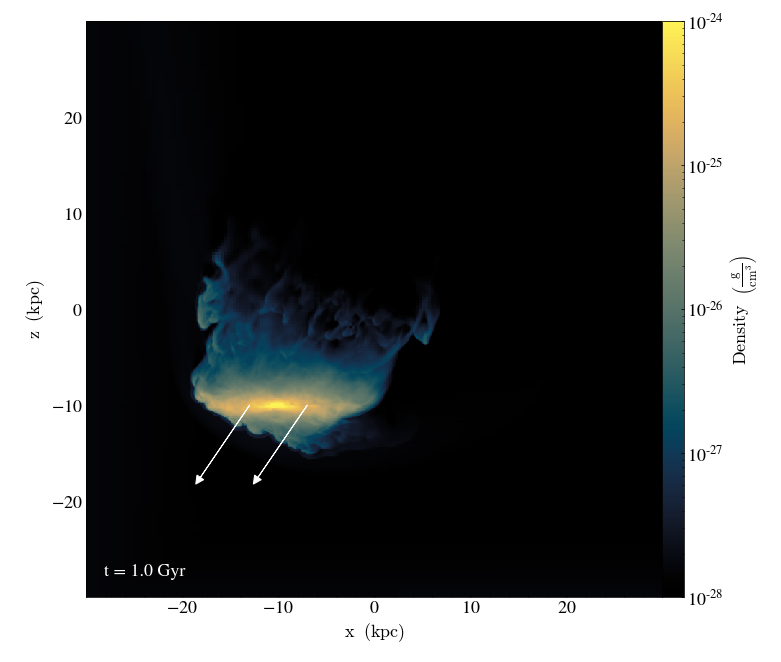

In [9]:
# If not already created, create a directory called LightRays to store the ray.h5 files in
import os
  
# Directory
directory = "LightRays"
  
if (os.path.exists(directory)==False):
    os.mkdir(directory)
    print("Directory '% s' created" % directory)


# Let's probe two different regions of the disk. The first ray will puncture close to the center, while another ray will puncture further out
start_coords1  = [-3.0,-3.0,0.0]
end_coords1 = [-3.0-0.561*10.0,-3.0-0.099*10.0,-0.822*10.0]
ray_start1 = kpc2codeunits(ds, start_coords1)
ray_end1 = kpc2codeunits(ds, end_coords1)
rayName1 = 'ray1'
line_list='all' # let Trident know about all the absorption lines

 
start_coords2   = [3.0,7.0,0.0]
end_coords2 = [3.0-0.561*10.0,7.0-0.099*10.0,-0.822*10.0]
ray_start2 = kpc2codeunits(ds, start_coords2)
ray_end2 = kpc2codeunits(ds, end_coords2)
rayName2 = 'ray2'
line_list='all'

ray1 = trident.make_simple_ray(ds,
                               start_position=ray_start1,
                               end_position=ray_end1,
                               data_filename=rayName1+'.h5',
                               lines=line_list,
                               ftype='gas')

ray2 = trident.make_simple_ray(ds,
                               start_position=ray_start2,
                               end_position=ray_end2,
                               data_filename=rayName2+'.h5',
                               lines=line_list,
                               ftype='gas')

# Show where the light rays start and end
q = yt.ProjectionPlot(ds, 1, 'density', weight_field='ism ')
q.annotate_timestamp()
q.annotate_ray(ray1, arrow=True)
q.annotate_ray(ray2, arrow=True)
q.set_cmap('density', 'cmr.eclipse')
q.set_zlim('density', 1e-28, 1e-24)
q.show()



Now let's generate a spectrum. Let's focus on wavelengths between 1150 and 1300 angstroms, where we'll find Si II and Si III lines

In [10]:
lambda_min,lambda_max = 1150, 1300
sg1 = trident.SpectrumGenerator(lambda_min=lambda_min, lambda_max=lambda_max, dlambda=0.01)
sg1.make_spectrum(ray1, lines='all', use_peculiar_velocity=True,
                  store_observables=True)
sg1.add_milky_way_foreground()
sg1.apply_lsf(filename='avg_COS.txt')
sg1.add_gaussian_noise(30)
sg1.save_spectrum('LightRays/spec_all_ray1.h5')

sg2 = trident.SpectrumGenerator(lambda_min=lambda_min, lambda_max=lambda_max, dlambda=0.01)
sg2.make_spectrum(ray2, lines='all', use_peculiar_velocity=True,
                 store_observables=True)
sg2.add_milky_way_foreground()
sg2.apply_lsf(filename='avg_COS.txt')
sg2.add_gaussian_noise(30)
sg2.save_spectrum('LightRays/spec_all_ray2.h5')

yt : [INFO     ] 2023-05-09 09:09:02,542 Setting instrument to Custom
yt : [INFO     ] 2023-05-09 09:09:02,658 Allocating for 1.070e+02 particles
yt : [INFO     ] 2023-05-09 09:09:02,871 Using all 213 available lines in 'lines.txt'.
yt : [INFO     ] 2023-05-09 09:09:02,882 Creating C_p0_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:02,901 Creating C_p1_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:02,911 Creating C_p2_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:02,920 Creating C_p3_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:02,930 Creating N_p0_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:02,951 Creating N_p1_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:02,961 Creating N_p2_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:02,984 Creating N_p3_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:02,999 Creating N_p4_

Adding line - C II 1335 [1334.532000 A]:  99%|█████████▉| 106/107 [00:00<00:00, 1308.84it/s]
yt : [INFO     ] 2023-05-09 09:09:07,686 26 out of 107 line components are unresolved.
Adding line - C II* 1037 [1037.018000 A]:  99%|█████████▉| 106/107 [00:00<00:00, 874.41it/s]
yt : [INFO     ] 2023-05-09 09:09:07,812 27 out of 107 line components are unresolved.
Adding line - C II 1036 [1036.337000 A]:  99%|█████████▉| 106/107 [00:00<00:00, 1028.74it/s]
yt : [INFO     ] 2023-05-09 09:09:07,920 33 out of 107 line components are unresolved.
Adding line - C II 904 [903.962000 A]:  99%|█████████▉| 106/107 [00:00<00:00, 736.29it/s]
yt : [INFO     ] 2023-05-09 09:09:08,075 31 out of 107 line components are unresolved.
Adding line - N I 1200 [1199.550000 A]:  99%|█████████▉| 106/107 [00:00<00:00, 4061.80it/s]
yt : [INFO     ] 2023-05-09 09:09:08,410 3 out of 107 line components are unresolved.
Adding line - N I 1134 [1134.165000 A]:  99%|█████████▉| 106/107 [00:00<00:00, 4508.54it/s]
yt : [INFO   

Adding line - Si III 1206 [1206.500000 A]:  99%|█████████▉| 106/107 [00:00<00:00, 1218.36it/s]
yt : [INFO     ] 2023-05-09 09:09:13,184 32 out of 107 line components are unresolved.
Adding line - Si IV 1403 [1402.770000 A]:  99%|█████████▉| 106/107 [00:00<00:00, 2977.61it/s]
yt : [INFO     ] 2023-05-09 09:09:13,233 33 out of 107 line components are unresolved.
Adding line - Fe II 924 [923.878210 A]:  99%|█████████▉| 106/107 [00:00<00:00, 6727.95it/s]
yt : [INFO     ] 2023-05-09 09:09:16,451 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2023-05-09 09:09:16,459 Applying specified line spread function.


yt : [INFO     ] 2023-05-09 09:09:16,467 Writing spectrum to hdf5 file: LightRays/spec_all_ray1.h5.
yt : [INFO     ] 2023-05-09 09:09:16,475 Setting instrument to Custom
yt : [INFO     ] 2023-05-09 09:09:16,590 Allocating for 1.210e+02 particles
yt : [INFO     ] 2023-05-09 09:09:16,804 Using all 213 available lines in 'lines.txt'.
yt : [INFO     ] 2023-05-09 09:09:16,818 Creating C_p0_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:16,826 Creating C_p1_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:16,831 Creating C_p2_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:16,836 Creating C_p3_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:16,841 Creating N_p0_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:16,849 Creating N_p1_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:16,854 Creating N_p2_number_density from ray's fields.
yt : [INFO     ] 2023-05-09 09:09:16,858 Cre

Adding line - C II 1036 [1036.337000 A]:  99%|█████████▉| 120/121 [00:00<00:00, 2326.94it/s]
yt : [INFO     ] 2023-05-09 09:09:20,509 30 out of 121 line components are unresolved.
Adding line - C II 904 [903.962000 A]:  99%|█████████▉| 120/121 [00:00<00:00, 1372.64it/s]
yt : [INFO     ] 2023-05-09 09:09:20,608 26 out of 121 line components are unresolved.
Adding line - N I 1134 [1134.165000 A]:  99%|█████████▉| 120/121 [00:00<00:00, 5299.91it/s]
yt : [INFO     ] 2023-05-09 09:09:21,044 30 out of 121 line components are unresolved.
Adding line - N I 952 [952.303000 A]:  99%|█████████▉| 120/121 [00:00<00:00, 5716.19it/s]
yt : [INFO     ] 2023-05-09 09:09:21,316 18 out of 121 line components are unresolved.
Adding line - N II 1084 [1083.990000 A]:  99%|█████████▉| 120/121 [00:00<00:00, 2318.31it/s]
yt : [INFO     ] 2023-05-09 09:09:21,373 30 out of 121 line components are unresolved.
Adding line - N II 916 [915.612000 A]:  99%|█████████▉| 120/121 [00:00<00:00, 2057.26it/s]
yt : [INFO     

Adding line - Si II 1808 [1808.013000 A]:  99%|█████████▉| 120/121 [00:00<00:00, 3691.55it/s]
yt : [INFO     ] 2023-05-09 09:09:23,761 30 out of 121 line components are unresolved.
Adding line - Si II 1190 [1190.416000 A]:  99%|█████████▉| 120/121 [00:00<00:00, 1424.55it/s]
yt : [INFO     ] 2023-05-09 09:09:24,759 32 out of 121 line components are unresolved.
Adding line - Si II 990 [989.873000 A]:  99%|█████████▉| 120/121 [00:00<00:00, 2440.06it/s]
yt : [INFO     ] 2023-05-09 09:09:24,945 30 out of 121 line components are unresolved.
Adding line - Si III 1206 [1206.500000 A]:  99%|█████████▉| 120/121 [00:00<00:00, 1637.36it/s]
yt : [INFO     ] 2023-05-09 09:09:25,026 29 out of 121 line components are unresolved.
Adding line - Si IV 1403 [1402.770000 A]:  99%|█████████▉| 120/121 [00:00<00:00, 3353.07it/s]
yt : [INFO     ] 2023-05-09 09:09:25,074 35 out of 121 line components are unresolved.
Adding line - Si XII 499 [499.406000 A]:  99%|█████████▉| 120/121 [00:00<00:00, 4769.64it/s]
yt 

Adding line - Ca X 558 [557.765000 A]:  99%|█████████▉| 120/121 [00:00<00:00, 4938.06it/s]
yt : [INFO     ] 2023-05-09 09:09:27,486 31 out of 121 line components are unresolved.
Adding line - Fe II 1608 [1608.450830 A]:  99%|█████████▉| 120/121 [00:00<00:00, 2736.86it/s]
yt : [INFO     ] 2023-05-09 09:09:27,534 34 out of 121 line components are unresolved.
Adding line - Fe II 924 [923.878210 A]:  99%|█████████▉| 120/121 [00:00<00:00, 6263.04it/s]
yt : [INFO     ] 2023-05-09 09:09:27,958 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2023-05-09 09:09:27,970 Applying specified line spread function.
yt : [INFO     ] 2023-05-09 09:09:27,974 Writing spectrum to hdf5 file: LightRays/spec_all_ray2.h5.


yt : [INFO     ] 2023-05-09 09:22:20,662 Setting instrument to Custom
yt : [INFO     ] 2023-05-09 09:22:20,716 Writing spectrum plot to png file: LightRays/COS130_1150_1300_allLines.png


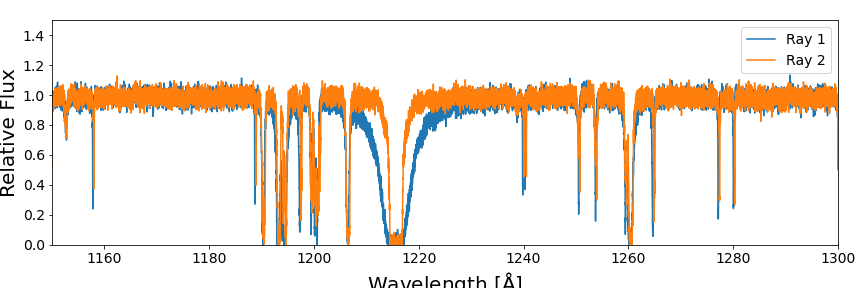

In [14]:
from IPython.display import display, Image


# Load the saved spectra and plot them together
sg1 = trident.load_spectrum('LightRays/spec_all_ray1.h5')
sg2 = trident.load_spectrum('LightRays/spec_all_ray2.h5')

filename = 'LightRays/COS130_1150_1300_allLines.png'
plot_spectrum_Chad([sg1.lambda_field,sg2.lambda_field],
        [sg1.flux_field,sg2.flux_field],
        flux_limits = [0,1.5],
        stagger=0.0, step=[True, True],
        label=['Ray 1', 'Ray 2'], filename=filename)

fig = Image(filename=filename)
display(fig)

We see a lot of overlapping absorption lines between Ray 1 and Ray 2, except for around 1210-1220 A. Let's zoom in on this region and label a few lines that I know are interesting: Si III 1206.5 and Lyman alpha. 

yt : [INFO     ] 2023-05-09 09:23:01,849 Setting instrument to Custom
yt : [INFO     ] 2023-05-09 09:23:01,864 Creating spectrum
Adding line - Ly a [1215.670000 A]:  99%|█████████▉| 106/107 [00:00<00:00, 286.22it/s]
yt : [INFO     ] 2023-05-09 09:23:02,280 33 out of 107 line components are unresolved.
Adding line - Si III 1206 [1206.500000 A]:  99%|█████████▉| 106/107 [00:00<00:00, 1624.26it/s]
yt : [INFO     ] 2023-05-09 09:23:02,349 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2023-05-09 09:23:02,356 Applying specified line spread function.
yt : [INFO     ] 2023-05-09 09:23:02,359 Writing spectrum to hdf5 file: LightRays/spec_SiIII_Lya_ray1.h5.
yt : [INFO     ] 2023-05-09 09:23:02,363 Setting instrument to Custom
yt : [INFO     ] 2023-05-09 09:23:02,373 Creating spectrum
Adding line - Ly a [1215.670000 A]:  99%|█████████▉| 120/121 [00:00<00:00, 551.51it/s]
yt : [INFO     ] 2023-05-09 09:23:02,625 30 out of 121 line components are unresolved.

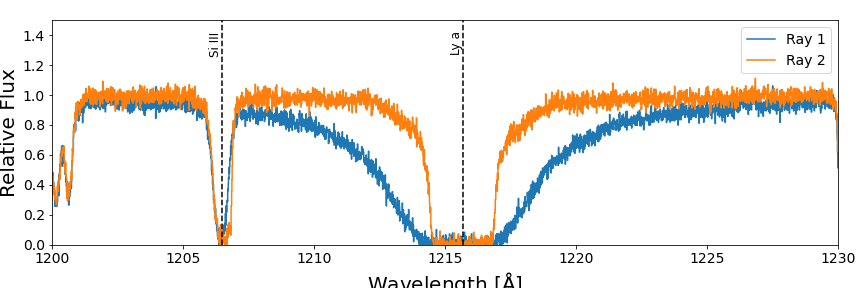

In [16]:
lambda_min,lambda_max = 1200, 1230
sg1 = trident.SpectrumGenerator(lambda_min=lambda_min, lambda_max=lambda_max, dlambda=0.01)
sg1.make_spectrum(ray1, lines={'Si III 1206','Ly a'}, use_peculiar_velocity=True,
                  store_observables=True)
sg1.add_milky_way_foreground()
sg1.apply_lsf(filename='avg_COS.txt')
sg1.add_gaussian_noise(30)
sg1.save_spectrum('LightRays/spec_SiIII_Lya_ray1.h5')

sg2 = trident.SpectrumGenerator(lambda_min=lambda_min, lambda_max=lambda_max, dlambda=0.01)
sg2.make_spectrum(ray2, lines={'Si III 1206', 'Ly a'}, use_peculiar_velocity=True,
                 store_observables=True)
sg2.add_milky_way_foreground()
sg2.apply_lsf(filename='avg_COS.txt')
sg2.add_gaussian_noise(30)
sg2.save_spectrum('LightRays/spec_SiIII_Lya_ray2.h5')

plot_spectrum_Chad([sg1.lambda_field,sg2.lambda_field],
        [sg1.flux_field,sg2.flux_field],
        flux_limits = [0,1.5],
        features={'Si III' : 1206.5, 'Ly a' : 1215.67},
        stagger=0.0, step=[True, True],
        label=['Ray 1', 'Ray 2'], filename='LightRays/COS130_1200_1230_SiIII_Lya.png')

display(Image("LightRays/COS130_1200_1230_SiIII_Lya.png", embed=True))

The width of absorption lines, like the Lyman Alpha line shown above, are partially due to turbulent velocity dispersion, i.e. the random motions of fluid elements that redshift and blueshift the light we see on Earth. 

In [18]:
# Calculate the velocity standard deviation weighted by density

 # Profile plots
raydat = ray1.all_data()
losvel = (raydat['velocity_los']/100000)*raydat['density'] 
print("Value along ray 1: ")
print(np.std(losvel))

raydat = ray2.all_data()
losvel = (raydat['velocity_los']/100000)*raydat['density'] 
print("Value along ray 2: ")
print(np.std(losvel))

Value along ray 1: 
2.3913198647901003e-24 g/(cm**2*s)
Value along ray 2: 
6.301139948527954e-25 g/(cm**2*s)


Turbulent motions are indeed stronger along ray 1 than ray 2, likely accounting for the increased line broadening. In fact, this interpretation makes physical sense given that ray 1 is closer to the LMC center where more star formation and wind driving occur, generating larger velocity and kinetic energy fluctuations.

## Other useful mock observables: gamma-ray emission, Faraday rotation measure, and H-alpha emission
#### Some outcomes of this analysis can be found in Bustard et al. 2020 ApJ (and various AAS poster presentations by UW undergraduates), Ciampa et al. 2021 ApJ, and Livingston et al. 2023, in prep. 

#### Faraday rotation measure
The line-of-sight (LOS) magnetic field strength is commonly probed by Faraday rotation measure, an integral along the LOS with dependence on the LOS magnetic field strength, B$_{\rm LOS}$ and the electron number density, $n_{e}$. 

Because $n_{e}$ depends on the ionization state of the gas, this is more complex to calculate and can't be simply pulled out from yt. Here, we've loaded in tables of $n_{e}/n_{H}$ as a function of the hydrogen number density $n_{H}$ and the gas temperature. We then use a bilinear interpolator to interpolate between values in this 2D space.

In [19]:
from numpy import *
import h5py
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from yt.fields import interpolated_fields
from yt.fields.field_detector import \
    FieldDetector
from yt.utilities.linear_interpolators import \
    BilinearFieldInterpolator

ds = yt.load("windCRs_hdf5_plt_cnt_0050")

# pre-tabulated text files for ne/nH, T, nH
nenh = loadtxt('nenh.txt')
tempTxt = loadtxt('Temps.txt')
nHTxt = loadtxt('NH.txt')

# ne/nH
def _nenh_interp(field, data):
    # use yt's bilinear interpolator:
    interp = BilinearFieldInterpolator(nenh,boundaries=[tempTxt,nHTxt],field_names=['temperature','number_density'], truncate=True)
 
    field_data = interp(data)
    field_data[field_data < 0] = 0.01 # if extrapolating, set a floor value of 1/100 -- this is a bit arbitrary and could be improved in the future
    return(field_data)
 
ds.add_field(('gas','nenh_interp'), function=_nenh_interp, units="", take_log=False, display_name=r'$n_{e} / n_{H}$', sampling_type="cell")

def _log10_nenh_interp(field, data): # create the log10 version too just for ease
    return(np.log10(data['nenh_interp']))

ds.add_field(('gas','log10_nenh_interp'), function=_log10_nenh_interp, units="", take_log=False, display_name=r'log10($n_{e} / n_{H}$)', sampling_type="cell")


# Rotation measure
def _rotationMeasure(field, data):
    # use yt's bilinear interpolator:
    interp = BilinearFieldInterpolator(nenh,boundaries=[tempTxt,nHTxt], 
                                    field_names=['temperature','number_density'], truncate=True)
    field_data = interp(data)
    field_data[field_data < 0] = 0.01
    return 0.812*field_data*data['number_density']*((-0.561*data['magnetic_field_x'] 
                        + 0.099*data['magnetic_field_y']
                        + 0.822*data['magnetic_field_z'])/1.e-6)*(1./3.0856e18)
 
ds.add_field(('gas','rotationMeasure'), function=_rotationMeasure, units="gauss/cm**3", take_log=False, display_name='Rotation Measure', sampling_type="cell")

# B_LOS
def _losBField(field,data):
    return (-0.561*data['magnetic_field_x'] + 0.099*data['magnetic_field_y'] + 0.822*data['magnetic_field_z'])/1.e-6
 
ds.add_field(('gas','losBField'), function=_losBField, units="gauss", take_log=False, display_name='Line of Sight B Field', sampling_type="cell")


yt : [INFO     ] 2023-05-09 09:24:16,905 Parameters: current_time              = 3.156010944496386e+16
yt : [INFO     ] 2023-05-09 09:24:16,907 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2023-05-09 09:24:16,909 Parameters: domain_left_edge          = [-6.171e+22 -6.171e+22 -6.171e+22]
yt : [INFO     ] 2023-05-09 09:24:16,911 Parameters: domain_right_edge         = [1.234e+23 1.234e+23 1.234e+23]
yt : [INFO     ] 2023-05-09 09:24:16,913 Parameters: cosmological_simulation   = 0


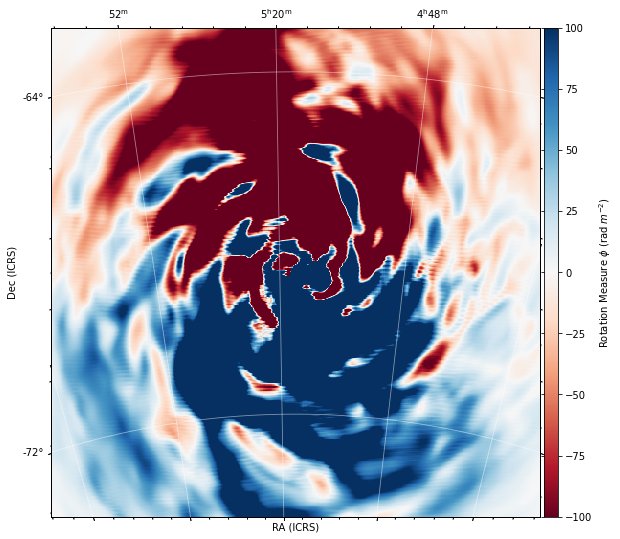

In [21]:
# Now plot the rotation measure as a mock observation

# first create a FITS file with rotation measure we can call on later
prj_fits = yt.FITSOffAxisProjection(ds,L,'rotationMeasure',center = (0,0,0), width=(10, 'kpc'))
sky_center = [79.0,-68.68] # in degrees
sky_scale = (4123.71, "arcsec/kpc") # could also use a YTQuantity
prj_fits.create_sky_wcs(sky_center, sky_scale, ctype=["RA---TAN","DEC--TAN"],  replace_old_wcs=True)
prj_fits.writeto("LMC_Ram_evolved_Faraday.fits", overwrite=True)
image_data = fits.getdata('LMC_Ram_evolved_Faraday.fits')
 
# open the FITS file and plot rotation measure
fig = aplpy.FITSFigure("LMC_Ram_evolved_Faraday.fits")
fig.add_grid()
fig.show_colorscale(cmap="RdBu",stretch = 'linear',vmin=-100, vmax = 100)
fig.tick_labels.set_xposition("top")
fig.ticks.set_xspacing(8.0)
fig.ticks.set_yspacing(8.0)
fig.add_colorbar()
fig.tick_labels.set_xformat('hh:mm')
fig.tick_labels.set_yformat('dd')
fig.colorbar.set_axis_label_text(r'Rotation Measure $\phi$ (rad $ m^{-2}$)')

On the surface, this map looks quite reasonable...|RM| is highest near the center of the galaxy where both the density and magnetic field strength are presumably the largest, and due to the tilt of the galaxy, the B field is primarily directed toward us in the lower half and away from us in the upper half of the image. However, these RM values are quite a bit higher than what is *observed*, suggesting that either the electron density or magnetic field strength are too high. *Or* it could be that neither is, on average, too large, but they are too large in the same locations.

Let's take a look at both $n_{e}/n_{H}$ and $B_{los}$

yt : [INFO     ] 2023-05-09 09:29:23,039 xlim = -15428387904811624824832.000000 15428387904811624824832.000000
yt : [INFO     ] 2023-05-09 09:29:23,040 ylim = -15428387904811624824832.000000 15428387904811624824832.000000
yt : [INFO     ] 2023-05-09 09:29:23,041 zlim = -92554999999999995019264.000000 92554999999999995019264.000000
yt : [INFO     ] 2023-05-09 09:29:23,044 Making a fixed resolution buffer of (('gas', 'nenh_interp')) 800 by 800



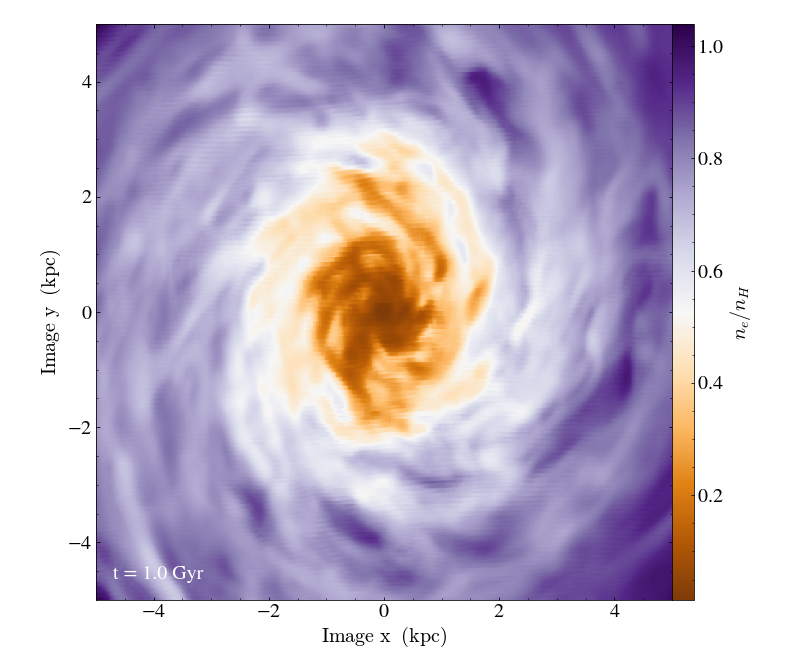

yt : [INFO     ] 2023-05-09 09:30:37,309 xlim = -15428387904811624824832.000000 15428387904811624824832.000000
yt : [INFO     ] 2023-05-09 09:30:37,309 ylim = -15428387904811624824832.000000 15428387904811624824832.000000
yt : [INFO     ] 2023-05-09 09:30:37,310 zlim = -92554999999999995019264.000000 92554999999999995019264.000000
yt : [INFO     ] 2023-05-09 09:30:37,312 Making a fixed resolution buffer of (('gas', 'losBField')) 800 by 800



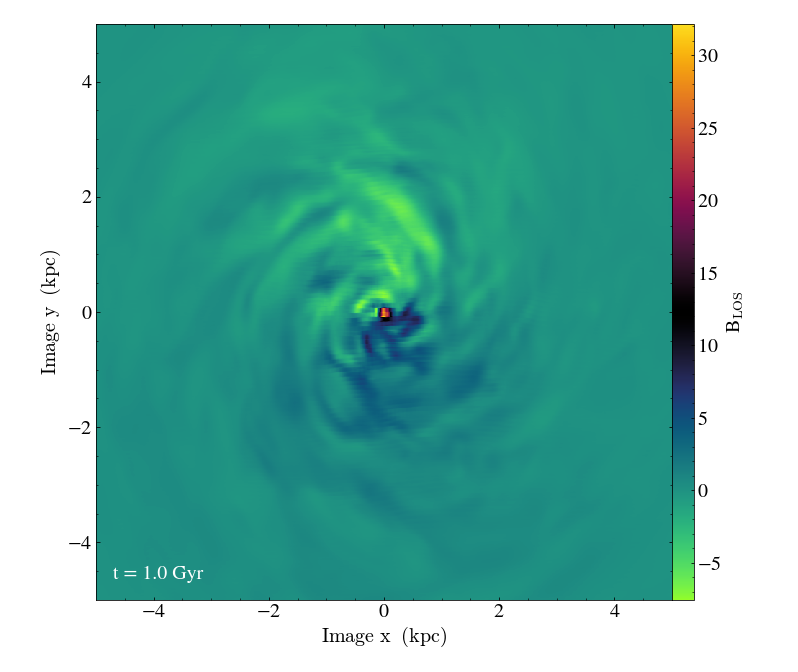

In [22]:
# Now plot ne/nH to get a sense of how ionized the gas is.
region = ds.box([0.0,-6.17E22,-3.0856E22],[1.2E23,6.17E22,3.0856E22])
L = [-0.561,0.099,0.822] # vector normal to cutting plane
d = yt.OffAxisProjectionPlot(ds, L, 'nenh_interp',weight_field="density",center=[0.0,0.0,0.0], width=(10, 'kpc'),fontsize=20)
d.set_cmap(field="nenh_interp", cmap='PuOr')
d.set_colorbar_label("nenh_interp", "$n_{e}/n_{H}$")
d.annotate_timestamp()
d.show()

d = yt.OffAxisProjectionPlot(ds, L, "losBField",weight_field="density",center=[0.0,0.0,0.0], width=(10, 'kpc'),fontsize=20)
d.set_cmap(field="losBField", cmap='cmr.wildfire')
d.set_colorbar_label("losBField", r"B$_{\rm LOS}$")
d.annotate_timestamp()
d.show()

Let's also make a phase plot showing cell-by-cell how the gas density, temperature, and ionization given by $n_{e}/n_{H}$ correlate.


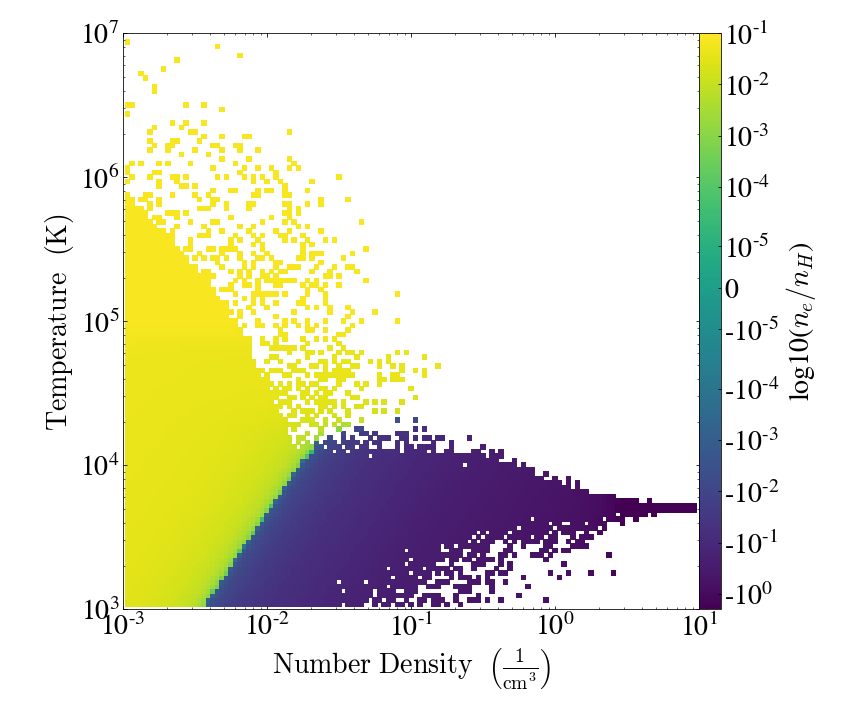

In [23]:
dd = ds.all_data()
plot = yt.PhasePlot(dd, "number_density", "temperature", "log10_nenh_interp",fontsize = 28)
# plot.set_cmap(field="magnetic_field_magnitude", cmap='viridis')
plot.set_cmap(field="log10_nenh_interp", cmap='viridis')
plot.set_ylim(1.E3,1.E7)
plot.set_xlim(1.E-3,1.E1)
# plot.set_zlim(field='magnetic_field_magnitude', zmin=1.E-8, zmax=1.E-5)
plot.set_zlim(field='log10_nenh_interp', zmin=-2, zmax=0.1)
plot.show()


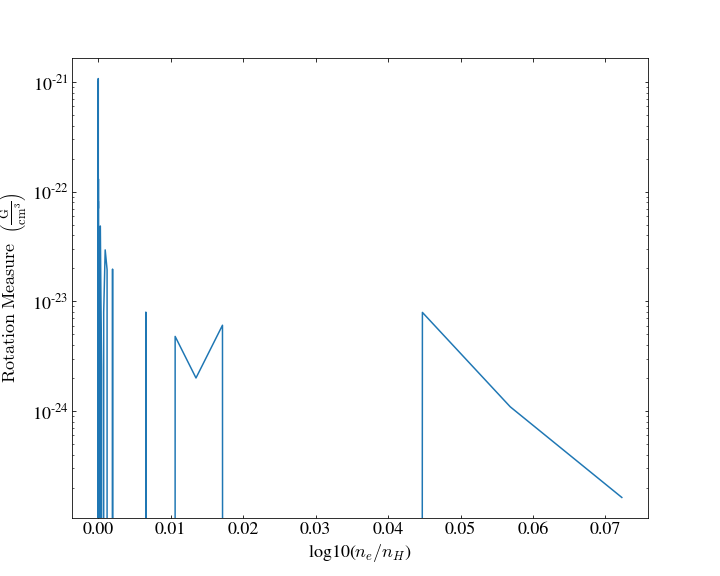

In [24]:
# Check a mass-weighted PDF of ne/nh -- how much of the gas (by mass) has hit the floor I've imposed on ne/nh?
plot = yt.ProfilePlot(
    dd,
    ("gas", "log10_nenh_interp"),
    [("gas", "rotationMeasure")],accumulation=False
)
plot.set_log(("gas", "log10_nenh_interp"), False)
plot.show()

A huge fraction of the rotation measure comes from cells with floored ne/nh = 1e-2. Yikes! 

The lesson: gas ionization is hard to model, and this implementation, which assumes photoionization equilibrium and neglects things like local ionizing radiation fields from massive stars in the LMC disk, is too naive. Nevertheless, the LMC simulations presented here provide useful comparisons to observations *when a thorough analysis is done and their limitations are known*

#### H$\alpha$ emission -- probing ~ 2e4 K gas

This shows a quick example of how to measure H-alpha emission from a series of simulation snapshots. For our example, we just use one snapshot, but this script can be applied to any other FLASH simulation output with a "cooling" output variable capturing the radiative cooling rate (See Bustard and Gronke 2022 for a use-case involving idealized simulations of the Magellanic Stream compared to real H-alpha observations)

Input: Set of simulation snapshots
Output: A rough image, a table with columns = (time, max emission, average emission, standard deviation of emission)

yt : [ERROR    ] 2023-05-09 09:34:44,462 Could not enable parallelism: only one mpi process is running. To remedy this, launch the Python interpreter as
  mpirun -n <X> python3 <yourscript>.py  # with X > 1 
yt : [INFO     ] 2023-05-09 09:34:44,567 Parameters: current_time              = 3.156010944496386e+16
yt : [INFO     ] 2023-05-09 09:34:44,569 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2023-05-09 09:34:44,571 Parameters: domain_left_edge          = [-6.171e+22 -6.171e+22 -6.171e+22]
yt : [INFO     ] 2023-05-09 09:34:44,573 Parameters: domain_right_edge         = [1.234e+23 1.234e+23 1.234e+23]
yt : [INFO     ] 2023-05-09 09:34:44,574 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-05-09 09:34:47,709 xlim = -15428387904811624824832.000000 15428387904811624824832.000000
yt : [INFO     ] 2023-05-09 09:34:47,710 ylim = -15428387904811624824832.000000 15428387904811624824832.000000
yt : [INFO     ] 2023-05-09 09:34:47,710 zlim = -92554999999999


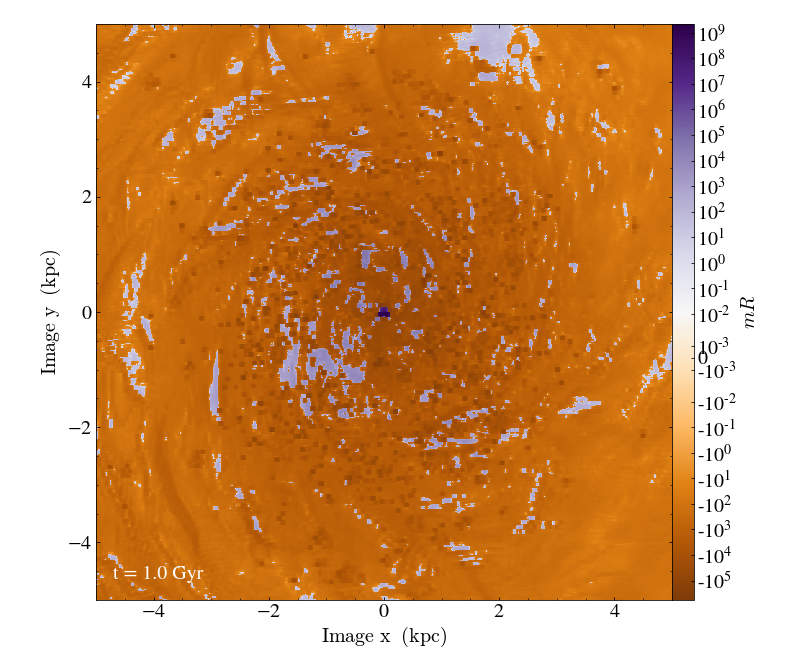

yt : [INFO     ] 2023-05-09 09:35:40,291 Projection completed
yt : [INFO     ] 2023-05-09 09:35:40,300 Making a fixed resolution buffer of (CoolingmR) 128 by 128


Dataset                          Time       Lum Max    Lum average    Lum std dev       
---------------------------------------------------------------------------------------------------------------------------------------    
 windCRs_hdf5_plt_cnt_0050       1000.080      4.11e+07 mR     8.7e+04 mR     1.89e+06 mR       



In [25]:
import matplotlib as plt
from yt.units import Mpc
import collections
import glob

yt.enable_parallelism()

pUnit = YTQuantity(1, 'cm**2/s**2')

# New function that takes in cooling rate ('cloo') and converts it to H-alpha luminosity
def CoolingmR(field,data):
    return data['cloo']*YTQuantity(1,'erg/cm**3/s')/(4.0*np.pi*2.41e-10) # in mR

yt.add_field(("gas","CoolingmR"), function=CoolingmR, sampling_type='local',units="erg/cm**3/s")


num_procs = 1

# Could load in more than one data file and create a table with H-alpha statistics,
# but here we only use one data file (the one we downloaded)
fns = glob.glob('windCRs_hdf5_plt_cnt_0050*')
fns.sort()

# Create an empty dictionary
data = {}

# Iterate through each dataset in the Time Series (using piter allows it
# to happen in parallel automatically across available processors)
for sto,fn in yt.parallel_objects(fns,num_procs,storage=data):
    ds = yt.load(fn)
    ad = ds.all_data()
    # ds.periodicity = (True,True,True) # deprecated
    ds.coordinates.x_axis[1] = 0
    ds.coordinates.y_axis[1] = 2
    
    L = [-0.561,0.099,0.822] # vector normal to cutting plane
    d = yt.OffAxisProjectionPlot(ds, L, 'CoolingmR',center=[0.0,0.0,0.0], width=(10, 'kpc'),fontsize=20)
    d.set_cmap(field="CoolingmR", cmap='PuOr')
    d.set_colorbar_label("CoolingmR", "$mR$")
    d.annotate_timestamp()
    d.show()
    
    dense_ad = ad.cut_region(['obj["CoolingmR"] > 0.0'])
    # c = yt.ProjectionPlot(ds, 1, "cloo",weight_field="density",fontsize=28)
    proj = ds.proj("CoolingmR",1,data_source=dense_ad)
    
    #degrade the resolution to [nx,ny] -- we can play with this to mock the effects of lower resolution instruments
    frb = proj.to_frb(width=(100,'kpc'),resolution=[128,128]) 
    my_image = np.array(frb["CoolingmR"])
    
    #filtered_image = np.array(filter(lambda num: num > 0.0, my_image))
    filtered_image = my_image[my_image > 0.0]
    
    # get max, avg, and standard deviation of cells with >0 emission
    maxCol = np.amax(filtered_image)
    avgCol = np.average(filtered_image)
    stdCol = np.std(filtered_image)

    # Fill the dictionary with extrema and redshift information for each dataset
    time = ds.current_time.in_units('Myr')
    sto.result_id = ds.basename
    sto.result = (time, maxCol, avgCol, stdCol)
   # data[ds.basename] = (time, extrema, var)
# Convert dictionary to ordered dictionary to get the right order

filename = "cool_file_res_128.txt"
cool_file = open(filename,"w")#write mode
#if yt.is_root()
cool_file.write("Dataset                          Time       Lum Max    Lum average    Lum std dev       \n")
cool_file.write("---------------------------------------------------------------------------------------------------------------------------------------    \n ")
for fn, val in sorted(data.items()):
    cool_file.write("%s       %05.3f      %5.3g mR     %5.3g mR     %5.3g mR       \n" % \
           (fn, val[0], val[1], val[2], val[3]))    

cool_file.close()

cool_file = open(filename, "r")
print(cool_file.read())


This script can be extended further to show H-alpha emission across different velocity channels, for instance to see how slow vs fast-moving gas compares in emission. This is left as an exercise for now, but see Ciampa+ 2020 (incl. Bustard) for an example. 


#### Gamma-ray emission (Under Construction)
When cosmic rays interact with normal, thermal gas via hadronic collisions, they produce pions that spontaneously decay into gamma-rays, very high-frequency waves (high energy photons) that are captured by state-of-the-art telescopes like Fermi. Here, we show how to map and quantify gamma-ray emission from the above LMC simulations.